In [1]:
import torch
from train.model import MNISTNeuralNet
import mlflow
from torchinfo import summary
from train.hyperparams import params

In [2]:

trackinguri = "http://127.0.0.1:5000/"

mlflow.set_tracking_uri(trackinguri)
client = mlflow.MlflowClient(tracking_uri=trackinguri)


In [3]:
mnist_model = MNISTNeuralNet(hidden_dim=params["hidden_dim"],dropout_prob=params["dropout_prob"])


## **Load Model by Run ID**

In [10]:
MLFLOW_EXPERIMENT_NAME = "Digit-Recognition"

In [11]:
experiment = mlflow.get_experiment_by_name(MLFLOW_EXPERIMENT_NAME)
exp_id = experiment.experiment_id if experiment else mlflow.create_experiment(MLFLOW_EXPERIMENT_NAME)
 


In [12]:
exp_id

'315412815950267867'

In [13]:
model_path = 'mlflow-artifacts:/315412815950267867/cbabe04a2e3d40b08ea4bfcefbf4210e/artifacts/model_weights/mnist_model_state_dict.pth'

In [14]:
ml_path = mlflow.artifacts.download_artifacts(model_path,dst_path='/statedict')

In [15]:
ml_path

'd:\\statedict\\mnist_model_state_dict.pth'

In [16]:
state_dict = torch.load(ml_path)
mnist_model.load_state_dict(state_dict)
mnist_model = mnist_model.eval()

MNISTNeuralNet(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
    (1): Dropout2d(p=0.2, inplace=True)
    (2): LeakyReLU(negative_slope=0.02, inplace=True)
    (3): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(8, 32, kernel_size=(3, 3), stride=(1, 1))
    (6): Dropout2d(p=0.4, inplace=True)
    (7): LeakyReLU(negative_slope=0.02, inplace=True)
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
    (11): Dropout2d(p=0.2, inplace=True)
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (linear): Sequential(
    (0): Linear(in_features=1024, out_features=400, bias=True)
    (1): LeakyReLU(negative_slop

In [4]:
from train.DataLoader import train_val_dataloader

Failed to download (trying next):
<urlopen error [Errno 110] Connection timed out>



100%|██████████| 9912422/9912422 [00:11<00:00, 895726.53it/s] 


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 110] Connection timed out>



100%|██████████| 28881/28881 [00:00<00:00, 104212.97it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 110] Connection timed out>



100%|██████████| 1648877/1648877 [00:01<00:00, 1052135.60it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 110] Connection timed out>



100%|██████████| 4542/4542 [00:00<00:00, 7620211.51it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [5]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [18]:
train_dataloader, val_dataloader = train_val_dataloader(batch_size=32)

In [16]:

def predict(model):

    import random

    # Get one batch from the validation dataloader
    images, labels = next(iter(val_dataloader))

    # Select a random index within the batch
    random_index = random.randint(0, images.size(0) - 1)

    # Extract the random image and its label
    image = images[random_index]
    true_label = labels[random_index]


    # Perform inference
    with torch.no_grad():
        output = model(image.unsqueeze(0))  # Add batch dimension
        predicted_label = torch.argmax(output, dim=1)
        confidence = output[0][predicted_label].item()*100  # Confidence of the predicted label


    # Display the image and inference result
    plt.imshow(image.squeeze(), cmap="gray")
    plt.title(f"True Label: {true_label.item()}, Predicted: {predicted_label.item()}\nConfidence: {confidence:.2f}%")
    plt.axis("off")
    plt.show()

In [ ]:
predict(model=mnist_model)

## **Load Staged Model for Inference**

In [6]:
model_name = "MNISTDigitRecognition"
stage = "production" 

latest_versions = client.get_latest_versions(name=model_name, stages=[stage])


/tmp/ipykernel_20261/1847435033.py:4: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  latest_versions = client.get_latest_versions(name=model_name, stages=[stage])


In [7]:
latest_versions[0]

<ModelVersion: aliases=[], creation_timestamp=1736944647401, current_stage='Production', description='', last_updated_timestamp=1736944654973, name='MNISTDigitRecognition', run_id='9f780b88ceaf41dfbea6a51be9048a24', run_link='', source='mlflow-artifacts:/912905627224081170/9f780b88ceaf41dfbea6a51be9048a24/artifacts/mymodel', status='READY', status_message='', tags={}, user_id='', version='1'>

In [8]:
latest_version = latest_versions[0]
model_version = latest_version.version
run_id = latest_version.run_id

In [9]:
artifact_uri = client.get_run(run_id).info.artifact_uri

In [10]:
artifact_uri

'mlflow-artifacts:/912905627224081170/9f780b88ceaf41dfbea6a51be9048a24/artifacts'

In [38]:
model_path = mlflow.artifacts.download_artifacts(artifact_uri=artifact_uri,
                                                 dst_path='/home/sushovan/STUDY/Digit-Recognition-App/statedict')


In [39]:
model_path

'/home/sushovan/STUDY/Digit-Recognition-App/statedict/artifacts'

In [13]:
ml_path = 'statedict/artifacts/model_weights/mnist_model_state_dict.pth'

In [14]:
state_dict = torch.load(ml_path)
mnist_model.load_state_dict(state_dict)
model = mnist_model.eval()

/tmp/ipykernel_20261/2319992755.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(ml_path)


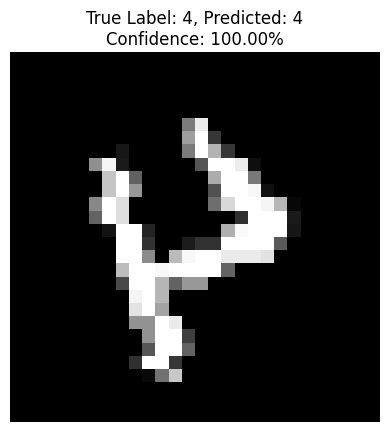

In [37]:
predict(model=model)